# Understanding pipelines, models and schedulers

Diffusers는 사용자 친화적이고 유연한 toolbox로, 사용 사례에 맞게 Diffusion system을 구축할 수 있도록 설계되었습니다. toolbox의 핵심에는 Model과 scheduler가 있습니다. DiffusionPipeline은 편의를 위해 이러한 구성 요소를 함께 묶지만, pipeline을 분해하여 model과 scheduler를 별도로 사용하여 새로운 diffusion 시스템을 만들 수도 있습니다.

이 Tutorial에서는 기본 파이프라인에서 시작하여 Stable Diffusion pipeline에 이르기까지 model과 scheduler를 사용하여 inference을 위한 Diffusion system을 조립하는 방법을 배울 수 있다.

## Deconstruct a basic pipeline
Pipeline은 inference을 위해 model을 실행하는 빠르고 쉬운 방법으로, 이미지를 생성하는 데 코드 4줄이면 된다. 

/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [00:11<00:00,  8.85it/s]


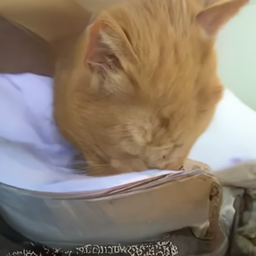

In [1]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")
image = ddpm(num_inference_steps=100).images[0]
image

위 예시에서는 pipeline은 __UNet2DModel__과 __DDPMScheduler__를 포함하고 있습니다. Pipeline은 원하는 출력 크기의 random noise를 모델을 통해 이미지의 noise를 제거합니다. 각 timestep에서 모델은 _noise residual_ 를 예측하고 scheduler는 이를 사용해 noise가 제거된 이미지를 예측합니다. Pipeline은 지정된 inference 단계의 끝에 도달할 때까지 이 과정을 반복합니다. 

1. Load the model and scheduler

In [2]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

2. Set the number of timesteps to run the denoising process for:

In [3]:
scheduler.set_timesteps(50)

3. Scheduler timestep을 설정하면, 이 예시에서는 50개의 요소가 균등하게 배치된 tensor가 생성됩니다. 각 요소는 모델이 이미지에서 noise를 제거하는 timestep에 해당됩니다. 나중에 noise 제거 loop를 생성할 때, 이 tensor를 반복하면서 이미지의 noise를 제거하게 됩니다. 

In [4]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

4. Create some random noise with the same shape as the desired output:

In [5]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device= "cuda")

5. 이제 timesteps를 반복하는 loop를 작성해보겠습니다. 각 timesteps마다, 모델은 UNet2DModel.forward() 메소드를 실행하여 noise가 있는 residual을 반환합니다. Scheduler의 step() 메소드는 noise가 있는 residual, timesteps, 그리고 입력을 받아 이전 timesteps에서의 이미지를 예측합니다. 이 출력은 denoising loop에서 모델의 다음 입력이 되며, timesteps 배열의 끝에 도달할 때까지 이 과정이 반복됩니다.

In [6]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

이것은 전체 noise 제거 프로세스이며, 이 동일한 패턴을 사용해 모든 diffusion system을 작성할 수 있습니다.

6. 마지막 단계는 noise가 제거된 출력을 이미지로 변환하는 것입니다. 

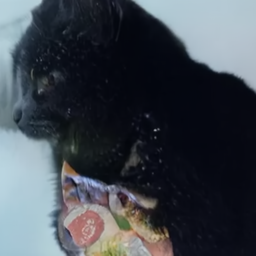

In [7]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

다음 section에서는 더 복잡한 Stable Diffusion pipeline을 분해합니다. 단계는 대체로 비슷합니다. 필요한 구성 요소를 초기화하고, timestep 배열을 생성하기 위해 timesteps 수를 설정합니다. timesteps 배열은 denoising loop에서 사용되며, 이 배열의 각 요소에 대해 모델은 덜 noisy한 이미지를 예측합니다. 이 과정은 timestep 끝까지 반복됩니다. 

이를 통해 복잡한 모델과 scheduler 구성을 이해하고, 각 구성 요소가 어떻게 상호 작용하는지 확인하면서, 시간에 따라 이미지에서 noise를 점진적으로 제거하는 방법을 배우게 됩니다. 

## Deconstruct the Stable Diffusion pipeline

Stable Diffusion은 텍스트에서 이미지로 변환하는 latent diffusion model입니다. 이 모델이 latent diffusion model이라고 하는 이유는 실제 픽셀 공간 대신 이미지의 저차원 표현을 사용하기 때문이며, 이를 통해 메모리 효율성이 높아집니다. encoder는 이미지를 더 작은 표현으로 압축하고, decoder는 압축된 표현을 다시 이미지로 변환합니다. 텍스트에서 이미지로의 모델을 위해서는 tokenizer와 text embedding을 생성하기 위한 인코더가 필요합니다. 

Stable Diffusion 모델에는 세 개의 pretrained model이 있습니다.

In [ ]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

디폴트 값인 __PNDMScheduler__ 대신에 UniPCMultistepScheduler를 사용할 수 있다. 

In [1]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


inference 속도를 높이기 위해 GPU를 활용할 수 있다. 

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

### Create text embeddings

다음 단계는 텍스트를 토큰화하여 임베딩을 생성합니다. 텍스트는 UNet 모델을 조건화하고 입력 prompt와 유사한 방향으로 diffusion process를 조정하는데 사용됩니다. 

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(0)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

텍스트를 토큰화하고, prompt로부터 임베딩을 만들어낸다. 

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

또한 패딩 토큰에 대한 임베딩인 unconditional text embedding을 생성해야 합니다. 이는 conditional text embeddings와 동일한 모양(batch_size, seq_length)를 가져야 합니다. 

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

conditional 과 unconditional embeddingd을 결합합니다. 

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### Create random noise
다음은, diffusion process의 시작점으로 일부 초기 random noise를 생성합니다. 이는 image의 latent representation이며 점차적으로 노이즈가 제거됩니다. 이 시점에서 latent image는 최종 이미지 크기보다 작지만 모델이 나중에 이를 최종 512x512크기로 변환하게 됩니다. 

In [ ]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

### Denoise the image

UniPCMultistepScheduler와 같은 개선된 Scheduler에 필요한 초기 noise distribution, sigma, noise scale 값으로 입력을 scaling하는 것부터 시작합니다.

In [ ]:
latents = latents * scheduler.init_noise_sigma

마지막 단계는 latent내의 pure noise를 prompt에 설명된 이미지로 점진적으로 변환하는 denoising loop를 만드는 것입니다. denoising loop는 세 가지 작업을 수행해야 합니다. denoising 중에 사용할 scheduler의 timestep을 설정합니다. timestep을 반복하고, 각 timestep에서 UNet 모델을 호출하여 noise residual을 예측하고 이를 Scheduler에 전달하여 이전 noise sample을 예측합니다. 

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

### Decode the image

마지막은 vae를 사용해 latent representation을 decoding하게 됩니다. 

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image